**Chapter 11 – Training Deep Neural Networks**

_This notebook contains all the sample code and solutions to the exercises in chapter 11._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# # Where to save the figures
# PROJECT_ROOT_DIR = "."
# CHAPTER_ID = "deep"
# IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
# os.makedirs(IMAGES_PATH, exist_ok=True)

# def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
#     path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
#     print("Saving figure", fig_id)
#     if tight_layout:
#         plt.tight_layout()
#     plt.savefig(path, format=fig_extension, dpi=resolution)

# Vanishing/Exploding Gradients Problem

Often gradients get smaller and smaller when backpropgating through each layer. Thus the lower layers weights change little, and as a result training never converges to a good solution. This is known as the vanishing gradients problem. Conversely, the gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges. This is the exploding gradients problem.

Generally deep neural networks suffer from unstable gradients and different layers may learn at different speeds.

The combination of the popular logistic sigmoid activation function and the weight initialization technique that was most popular at the time (i.e., a normal distribution with a mean of 0 and a standard deviation of 1). In short, they showed that with this activation function and this initialization scheme, the variance of the outputs of each layer is much greater than the variance of its inputs. Going forward in the network, the variance keeps increasing after each layer until the activation function saturates at the top layers. This saturation is actually made worse by the fact that the logistic function has a mean of 0.5, not 0.

When inputs become large (negative or positive), the function saturates at 0 or 1, with a derivative extremely close to 0. Thus, when backpropagation kicks in it has virtually no gradient to propagate back through the network; and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers.

In [3]:
def logit(z):
    return 1 / (1 + np.exp(-z))

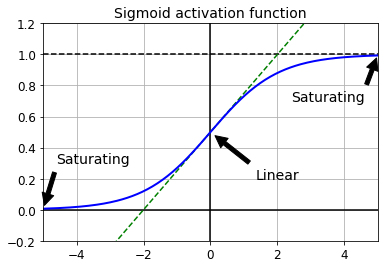

In [4]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

# save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

There exists methods to alleviate the unstable gradients problem. We want the signal to pass through correctly forwards, but also backwards! Need the variance of the outputs of each layer to be equal to the variance of its inputs, and we need the gradients to have equal variance before and after flowing through a layer in the reverse direction.

It is not possible to guarantee both unless the layer has an equal number of inputs and neurons (these numbers are called the fan-in and fan-out of the layer). The compromise is that the connection weights of each layer must be initialized randomly and $\text{fan}_{\text{avg}} = (\text{fan}_{\text{in}} + \text{fan}_{\text{out}}) / 2$ (Glorot initialization). 

Weights initialized to a normal distribution with mean 0 and variance $\sigma^2 = \frac{1}{\text{fan}_{\text{avg}}}$.

Or uniform distribution between $-r, +r$ with $r = \sqrt{\frac{3}{\text{fan}_{\text{avg}}}}$

Similar strategies exist:

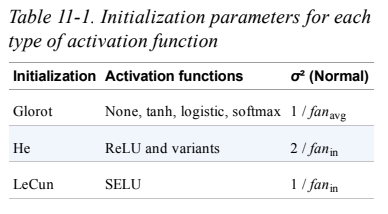

In [4]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

Keras by default uses glorot initialization with a uniform distribution. For each layer we can change the initialization like so:

In [5]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

Similarly, we can change the $\text{fan}$ parameter by using the VarianceScaling initializer:

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## Nonsaturating Activation Functions

### Leaky ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

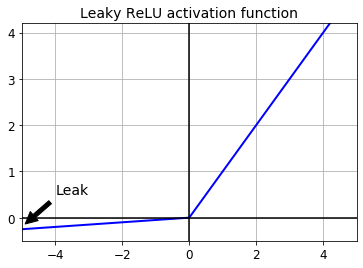

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

# save_fig("leaky_relu_plot")
plt.show()

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [11]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [13]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [14]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 3s 52us/sample - loss: 1.2810 - accuracy: 0.6205 - val_loss: 0.8869 - val_accuracy: 0.7160
Epoch 2/10
55000/55000 [==============================] - 2s 44us/sample - loss: 0.7952 - accuracy: 0.7368 - val_loss: 0.7132 - val_accuracy: 0.7626
Epoch 3/10
55000/55000 [==============================] - 3s 49us/sample - loss: 0.6817 - accuracy: 0.7726 - val_loss: 0.6385 - val_accuracy: 0.7896
Epoch 4/10
55000/55000 [==============================] - 2s 44us/sample - loss: 0.6219 - accuracy: 0.7942 - val_loss: 0.5931 - val_accuracy: 0.8016
Epoch 5/10
55000/55000 [==============================] - 2s 44us/sample - loss: 0.5829 - accuracy: 0.8074 - val_loss: 0.5607 - val_accuracy: 0.8164
Epoch 6/10
55000/55000 [==============================] - 3s 49us/sample - loss: 0.5552 - accuracy: 0.8172 - val_loss: 0.5355 - val_accuracy: 0.8240
Epoch 7/10
55000/55000 [==============================] -

Now let's try PReLU:

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [16]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [17]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 3s 49us/sample - loss: 1.3452 - accuracy: 0.6203 - val_loss: 0.9241 - val_accuracy: 0.7170
Epoch 2/10
55000/55000 [==============================] - 3s 52us/sample - loss: 0.8196 - accuracy: 0.7364 - val_loss: 0.7314 - val_accuracy: 0.7602
Epoch 3/10
55000/55000 [==============================] - 3s 49us/sample - loss: 0.6970 - accuracy: 0.7701 - val_loss: 0.6517 - val_accuracy: 0.7876
Epoch 4/10
55000/55000 [==============================] - 3s 52us/sample - loss: 0.6333 - accuracy: 0.7914 - val_loss: 0.6033 - val_accuracy: 0.8054
Epoch 5/10
55000/55000 [==============================] - 3s 58us/sample - loss: 0.5917 - accuracy: 0.8049 - val_loss: 0.5689 - val_accuracy: 0.8164
Epoch 6/10
55000/55000 [==============================] - 3s 53us/sample - loss: 0.5619 - accuracy: 0.8143 - val_loss: 0.5417 - val_accuracy: 0.8222
Epoch 7/10
55000/55000 [==============================] -

### ELU

In [18]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

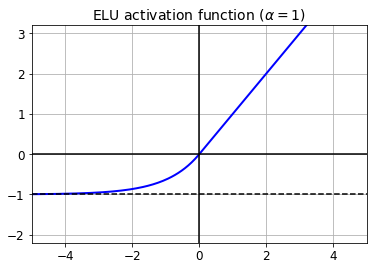

In [19]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

# save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [20]:
keras.layers.Dense(10, activation="elu")

### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ<sub>1</sub> or ℓ<sub>2</sub> regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [21]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [22]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

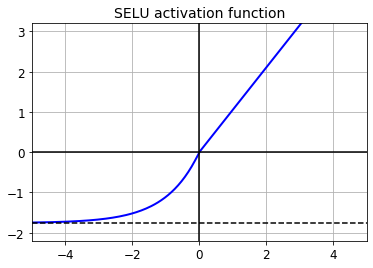

In [23]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

# save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [25]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using SELU is easy:

In [26]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [27]:
np.random.seed(42)
tf.random.set_seed(42)

In [28]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [29]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [30]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [31]:
# 5 times longer per sample! woah
# converges faster tho

history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 14s 259us/sample - loss: 1.4757 - accuracy: 0.4261 - val_loss: 0.9494 - val_accuracy: 0.6230
Epoch 2/5
55000/55000 [==============================] - 13s 242us/sample - loss: 0.8311 - accuracy: 0.6861 - val_loss: 0.7032 - val_accuracy: 0.7456
Epoch 3/5
55000/55000 [==============================] - 13s 229us/sample - loss: 0.6864 - accuracy: 0.7470 - val_loss: 0.6434 - val_accuracy: 0.7668
Epoch 4/5
55000/55000 [==============================] - 12s 213us/sample - loss: 0.6344 - accuracy: 0.7695 - val_loss: 0.5922 - val_accuracy: 0.7832
Epoch 5/5
55000/55000 [==============================] - 13s 241us/sample - loss: 0.6197 - accuracy: 0.7761 - val_loss: 0.5462 - val_accuracy: 0.7982


Now look at what happens if we try to use the ReLU activation function instead:

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

In [33]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [34]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [35]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 15s 271us/sample - loss: 1.7867 - accuracy: 0.2765 - val_loss: 1.5764 - val_accuracy: 0.3548
Epoch 2/5
55000/55000 [==============================] - 13s 237us/sample - loss: 1.1947 - accuracy: 0.4929 - val_loss: 1.7929 - val_accuracy: 0.2672
Epoch 3/5
55000/55000 [==============================] - 13s 228us/sample - loss: 0.9926 - accuracy: 0.5912 - val_loss: 1.1392 - val_accuracy: 0.5832
Epoch 4/5
55000/55000 [==============================] - 13s 232us/sample - loss: 0.9781 - accuracy: 0.6083 - val_loss: 0.9501 - val_accuracy: 0.6050
Epoch 5/5
55000/55000 [==============================] - 13s 236us/sample - loss: 0.8204 - accuracy: 0.6804 - val_loss: 0.7022 - val_accuracy: 0.7442


Not great at all, we suffered from the vanishing/exploding gradients problem.

Although your mileage will vary, in general SELU > ELU > leaky ReLU (and its variants) > ReLU > tanh > logistic. If the network’s architecture prevents it from self-normalizing, then ELU may perform better than SELU (since SELU is not smooth at z = 0). 

If you care a lot about runtime latency, then you may prefer leaky ReLU. If you don’t want to tweak yet another hyperparameter, you may use the default α values used by Keras (e.g., 0.3 for leaky ReLU). If you have spare time and computing power, you can use cross-validation to evaluate other activation functions, such as RReLU if your network is overfitting or PReLU if you have a huge training set. 

That said, because ReLU is the most used activation function (by far), many libraries and hardware  accelerators provide ReLU-specific optimizations; therefore, if speed is your priority, ReLU might still be the best choice.

# Batch Normalization

To reduce the danger of vanishing or exploding gradients we can use batch normalization. It adds an operation in the model just before or after the activation function of each hidden layer, where it zero-centers and normalizes each input and scales and shifts the result using two different parameters (one for scaling, one for shifting). This lets the model find the optimal scale and mean of each layers inputs. *If one adds a BN layer as the first layer of the neural network, one does not need to standardize the training set*.

The algorithm estimates each inputs mean and variance by evaluating the mean and std of the input over the current mini-batch. 

Equation 11-3 Batch Normalization algorithm

1. $$\mu_B = \frac{1}{m_B} \sum_{i=1}^{m_b} x^{(i)}$$


2. $$\sigma_B^2 = \frac{1}{m_B} \sum_{i=1}^{m_b} (x^{(i)} - \mu_B)^2$$


3. $$\hat{x}^{(i)} = \frac{x^{(i)} - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$$


4. $$z^{(i)} = \gamma \otimes \hat{x}^{(i)} + \beta$$


In this algorithm:

$\mu_B$ is the vector of input means, evaluated over the whole mini-batch $B$ (it contains one mean per input).

$\sigma_B$ is the vector of input standard deviations, also evaluated over the whole mini-batch (it contains one standard deviation per input).

$m_B$ is the number of instances in the mini-batch. 

$\hat{x}^{(i)}$ is the vector of zero-centered and normalized inputs for instance $i$.

$\gamma$ is the output scale parameter vector for the layer (it contains one scale parameter per input).

$\otimes$ represents element-wise multiplication (each input is multiplied by its corresponding output scale parameter).

$\beta$ is the output shift (offset) parameter vector for the layer (it contains one offset parameter per input). Each input is offset by its corresponding shift parameter.

$\epsilon$ is a tiny number that avoids division by zero (typically $10^{-5}$). This is called a smoothing term.

$z^{(i)}$ is the output of the BN operation. It is a rescaled and shifted version of the inputs.


Most implementations of Batch Normalization estimate final statistics during training by using a moving average of the layer’s input means and standard deviations. This is what Keras does automatically when you use the BatchNormalization layer. To sum up, four parameter vectors are learned in each batch-normalized layer: $\gamma$ (the output scale vector) and $\beta$ (the output offset vector) are learned through regular backpropagation, and $\mu$ (the final input mean vector) and $\sigma$ (the final input standard deviation vector) are estimated using an exponential moving average. Note that $\mu$ and $\sigma$ are estimated during training, but they are used only after training.

The vanishing gradients problem was strongly reduced, to the point that they could use saturating activation
functions such as the tanh and even the logistic activation function. The networks were also much less sensitive to the weight initialization. The authors were able to use much larger learning rates, significantly speeding up the learning process. Also, Batch Normalization acts like a regularizer, reducing the need for other regularization techniques.

In [38]:
#this model applies BN after every hidden layer and as the first layer in the model

# small model so BN may not have a positive impact, but larger models will have way better results!

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [39]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_215 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
dense_216 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)               400       
_________________________________________________________________
dense_217 (Dense)            (None, 10)               

In [40]:
# four additional params added
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization_3/gamma:0', True),
 ('batch_normalization_3/beta:0', True),
 ('batch_normalization_3/moving_mean:0', False),
 ('batch_normalization_3/moving_variance:0', False)]

In [41]:
bn1.updates

[<tf.Operation 'cond/Identity' type=Identity>,
 <tf.Operation 'cond_1/Identity' type=Identity>]

In [42]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [43]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 81us/sample - loss: 0.8528 - accuracy: 0.7140 - val_loss: 0.5573 - val_accuracy: 0.8104
Epoch 2/10
55000/55000 [==============================] - 4s 77us/sample - loss: 0.5732 - accuracy: 0.8014 - val_loss: 0.4792 - val_accuracy: 0.8386
Epoch 3/10
55000/55000 [==============================] - 4s 70us/sample - loss: 0.5153 - accuracy: 0.8212 - val_loss: 0.4427 - val_accuracy: 0.8454
Epoch 4/10
55000/55000 [==============================] - 4s 79us/sample - loss: 0.4834 - accuracy: 0.8324 - val_loss: 0.4197 - val_accuracy: 0.8532
Epoch 5/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.4562 - accuracy: 0.8402 - val_loss: 0.4062 - val_accuracy: 0.8582
Epoch 6/10
55000/55000 [==============================] - 4s 64us/sample - loss: 0.4388 - accuracy: 0.8469 - val_loss: 0.3951 - val_accuracy: 0.8618
Epoch 7/10
55000/55000 [==============================] -

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [44]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [45]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [46]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 73us/sample - loss: 1.0677 - accuracy: 0.6717 - val_loss: 0.6841 - val_accuracy: 0.7858
Epoch 2/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.6875 - accuracy: 0.7817 - val_loss: 0.5590 - val_accuracy: 0.8204
Epoch 3/10
55000/55000 [==============================] - 4s 72us/sample - loss: 0.5999 - accuracy: 0.8040 - val_loss: 0.5027 - val_accuracy: 0.8366
Epoch 4/10
55000/55000 [==============================] - 4s 73us/sample - loss: 0.5517 - accuracy: 0.8162 - val_loss: 0.4663 - val_accuracy: 0.8446
Epoch 5/10
55000/55000 [==============================] - 4s 69us/sample - loss: 0.5171 - accuracy: 0.8248 - val_loss: 0.4431 - val_accuracy: 0.8514
Epoch 6/10
55000/55000 [==============================] - 4s 71us/sample - loss: 0.4962 - accuracy: 0.8304 - val_loss: 0.4256 - val_accuracy: 0.8564
Epoch 7/10
55000/55000 [==============================] -

BN gives us many hyperparameters we can tweak, one main one would typically be momentum. It is used by the BatchNormalization layer when it updates exponential moving averages. A good momentum is typically close to 1.

## Gradient Clipping

To mitigate the exploding gradients problem, we can clip the gradients during backpropagation so they never exceed some threshold (think `pd.Series.clip()`)

All Keras optimizers accept `clipnorm` or `clipvalue` arguments:

In [44]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

This optimizer will clip every component of the gradient vector to a value
between –1.0 and 1.0. This means that all the partial derivatives of the loss
(with regard to each and every trainable parameter) will be clipped
between –1.0 and 1.0.

In [45]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

If you want to ensure that Gradient
Clipping does not change the direction of the gradient vector, you should
clip by norm by setting clipnorm instead of clipvalue. This will clip the
whole gradient if its $\ell_2$ norm is greater than the threshold you picked.

## Reusing Pretrained Layers

Generally not a good idea to train very large deep neural networks from scratch, instead use an existing network and adapt it for your purposes. This is called transfer learning. It will speed up training and require less training data.

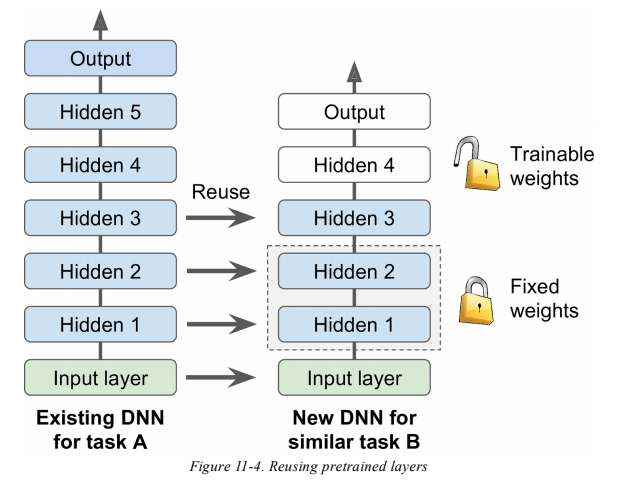

The output layer should usually be replaced, and sometimes many of the higher layers too. Try freezing all the reused layers first (i.e., make their weights non-trainable so that Gradient Descent won’t modify them), then train your model and see how it performs. Then try unfreezing one or two of the top
hidden layers to let backpropagation tweak them and see if performance
improves. The more training data you have, the more layers you can
unfreeze. It is also useful to reduce the learning rate when you unfreeze
reused layers: this will avoid wrecking their fine-tuned weights.

### Reusing a Keras model

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [47]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [48]:
X_train_A.shape

(43986, 28, 28)

In [49]:
X_train_B.shape

(200, 28, 28)

In [50]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [51]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [52]:
tf.random.set_seed(42)
np.random.seed(42)

In [53]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [54]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [55]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Train on 43986 samples, validate on 4014 samples
Epoch 1/20
43986/43986 [==============================] - 2s 53us/sample - loss: 0.5902 - accuracy: 0.8130 - val_loss: 0.3782 - val_accuracy: 0.8690
Epoch 2/20
43986/43986 [==============================] - 2s 47us/sample - loss: 0.3517 - accuracy: 0.8784 - val_loss: 0.3374 - val_accuracy: 0.8834
Epoch 3/20
43986/43986 [==============================] - 2s 47us/sample - loss: 0.3162 - accuracy: 0.8896 - val_loss: 0.3017 - val_accuracy: 0.8959
Epoch 4/20
43986/43986 [==============================] - 2s 55us/sample - loss: 0.2969 - accuracy: 0.8975 - val_loss: 0.2912 - val_accuracy: 0.9023
Epoch 5/20
43986/43986 [==============================] - 2s 50us/sample - loss: 0.2831 - accuracy: 0.9026 - val_loss: 0.2816 - val_accuracy: 0.9018
Epoch 6/20
43986/43986 [==============================] - 2s 55us/sample - loss: 0.2725 - accuracy: 0.9069 - val_loss: 0.2738 - val_accuracy: 0.9071
Epoch 7/20
43986/43986 [==============================] -

In [55]:
# model_A.save("my_model_A.h5")

In [56]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [57]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [58]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/20
200/200 [==============================] - 0s 1ms/sample - loss: 0.9509 - accuracy: 0.4800 - val_loss: 0.6533 - val_accuracy: 0.5568
Epoch 2/20
200/200 [==============================] - 0s 237us/sample - loss: 0.5837 - accuracy: 0.7100 - val_loss: 0.4825 - val_accuracy: 0.8479
Epoch 3/20
200/200 [==============================] - 0s 250us/sample - loss: 0.4527 - accuracy: 0.8750 - val_loss: 0.4097 - val_accuracy: 0.8945
Epoch 4/20
200/200 [==============================] - 0s 250us/sample - loss: 0.3869 - accuracy: 0.9050 - val_loss: 0.3630 - val_accuracy: 0.9209
Epoch 5/20
200/200 [==============================] - 0s 253us/sample - loss: 0.3404 - accuracy: 0.9300 - val_loss: 0.3302 - val_accuracy: 0.9280
Epoch 6/20
200/200 [==============================] - 0s 244us/sample - loss: 0.3073 - accuracy: 0.9350 - val_loss: 0.3026 - val_accuracy: 0.9381
Epoch 7/20
200/200 [==============================] - 0s 271us/sample - loss: 0.

In [59]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 784)               3136      
_________________________________________________________________
dense_218 (Dense)            (None, 300)               235200    
_________________________________________________________________
batch_normalization_7 (Batch (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_219 (Dense)            (None, 100)               30000     
_________________________________________________________________
batch_normalization_8 (Batch (None, 100)              

In [60]:
# model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [61]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [62]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

In [63]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/4
200/200 [==============================] - 0s 1ms/sample - loss: 0.1930 - accuracy: 0.9600 - val_loss: 0.2086 - val_accuracy: 0.9726
Epoch 2/4
200/200 [==============================] - 0s 234us/sample - loss: 0.1874 - accuracy: 0.9600 - val_loss: 0.2035 - val_accuracy: 0.9757
Epoch 3/4
200/200 [==============================] - 0s 235us/sample - loss: 0.1824 - accuracy: 0.9600 - val_loss: 0.1986 - val_accuracy: 0.9757
Epoch 4/4
200/200 [==============================] - 0s 247us/sample - loss: 0.1776 - accuracy: 0.9600 - val_loss: 0.1939 - val_accuracy: 0.9767
Train on 200 samples, validate on 986 samples
Epoch 1/16
200/200 [==============================] - 0s 1ms/sample - loss: 0.1648 - accuracy: 0.9600 - val_loss: 0.1691 - val_accuracy: 0.9817
Epoch 2/16
200/200 [==============================] - 0s 227us/sample - loss: 0.1414 - accuracy: 0.9700 - val_loss: 0.1515 - val_accuracy: 0.9828
Epoch 3/16
200/200 [====================

So, what's the final verdict?

In [64]:
model_B.evaluate(X_test_B, y_test_B)

2000/2000 [==============================] - 0s 29us/sample - loss: 0.1426 - accuracy: 0.9695


[0.14263125598430634, 0.9695]

In [65]:
model_B_on_A.evaluate(X_test_B, y_test_B)

2000/2000 [==============================] - 0s 34us/sample - loss: 0.0650 - accuracy: 0.9935


[0.06504784017801285, 0.9935]

Great! We got quite a bit of transfer: the error rate dropped by a factor of almost 4!

In [66]:
(100 - 97.05) / (100 - 99.25)

3.933333333333337

Cheated though! It turns out that transfer learning does not work very well
with small dense networks, presumably because small networks learn few
patterns, and dense networks learn very specific patterns, which are
unlikely to be useful in other tasks. Transfer learning works best with deep
convolutional neural networks, which tend to learn feature detectors that
are much more general

## Unsupervized Pretraining

Suppose you want to tackle a complex task for which you don’t have much
labeled training data, but unfortunately you cannot find a model trained on
a similar task.

If you can gather plenty of unlabeled training data, you can try to use it to train
an unsupervised model, such as an autoencoder or a generative adversarial
network (see Chapter 17). Then you can reuse the lower layers of the
autoencoder or the lower layers of the GAN’s discriminator, add the output
layer for your task on top, and fine-tune the final network using supervised
learning (i.e., with the labeled training examples).

Unsupervised pretraining (today typically using autoencoders or
GANs rather than RBMs) is still a good option when you have a complex
task to solve, no similar model you can reuse, and little labeled training
data but plenty of unlabeled training data.

People generally train the full
unsupervised model in one shot and use autoencoders or GANs rather than RBMs.

## Pretraining on an Auxiliary Task

If you do not have much labeled training data, one last option is to train a
first neural network on an auxiliary task for which you can easily obtain or
generate labeled training data, then reuse the lower layers of that network
for your actual task. The first neural network’s lower layers will learn
feature detectors that will likely be reusable by the second neural network.

# Faster Optimizers

## Momentum optimization

In [67]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

## Nesterov Accelerated Gradient

In [68]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

## AdaGrad

In [69]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

## RMSProp

In [70]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

## Adam Optimization

In [71]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

## Adamax Optimization

In [72]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)

## Nadam Optimization

In [73]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

## Learning Rate Scheduling

### Power Scheduling

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

In [74]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

In [75]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [76]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 4s 66us/sample - loss: 0.4840 - accuracy: 0.8296 - val_loss: 0.4038 - val_accuracy: 0.8630
Epoch 2/25
55000/55000 [==============================] - 3s 63us/sample - loss: 0.3787 - accuracy: 0.8653 - val_loss: 0.3846 - val_accuracy: 0.8706
Epoch 3/25
55000/55000 [==============================] - 3s 62us/sample - loss: 0.3461 - accuracy: 0.8770 - val_loss: 0.3606 - val_accuracy: 0.8776
Epoch 4/25
55000/55000 [==============================] - 3s 63us/sample - loss: 0.3248 - accuracy: 0.8844 - val_loss: 0.3661 - val_accuracy: 0.8738
Epoch 5/25
55000/55000 [==============================] - 3s 62us/sample - loss: 0.3092 - accuracy: 0.8902 - val_loss: 0.3516 - val_accuracy: 0.8792
Epoch 6/25
55000/55000 [==============================] - 3s 63us/sample - loss: 0.2967 - accuracy: 0.8938 - val_loss: 0.3467 - val_accuracy: 0.8810
Epoch 7/25
55000/55000 [==============================] -

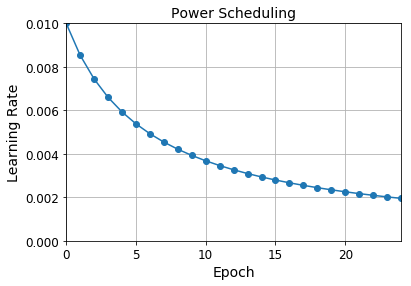

In [77]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

```lr = lr0 * 0.1**(epoch / s)```

In [78]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [79]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [80]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [81]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 6s 107us/sample - loss: 0.8245 - accuracy: 0.7595 - val_loss: 1.0870 - val_accuracy: 0.7106
Epoch 2/25
55000/55000 [==============================] - 6s 101us/sample - loss: 0.6391 - accuracy: 0.8064 - val_loss: 0.6125 - val_accuracy: 0.8160
Epoch 3/25
55000/55000 [==============================] - 6s 101us/sample - loss: 0.5962 - accuracy: 0.8174 - val_loss: 0.6526 - val_accuracy: 0.8086
Epoch 4/25
55000/55000 [==============================] - 5s 99us/sample - loss: 0.5420 - accuracy: 0.8306 - val_loss: 0.7521 - val_accuracy: 0.7766
Epoch 5/25
55000/55000 [==============================] - 5s 100us/sample - loss: 0.4853 - accuracy: 0.8460 - val_loss: 0.5616 - val_accuracy: 0.8314
Epoch 6/25
55000/55000 [==============================] - 5s 98us/sample - loss: 0.4443 - accuracy: 0.8571 - val_loss: 0.5430 - val_accuracy: 0.8664
Epoch 7/25
55000/55000 [=============================

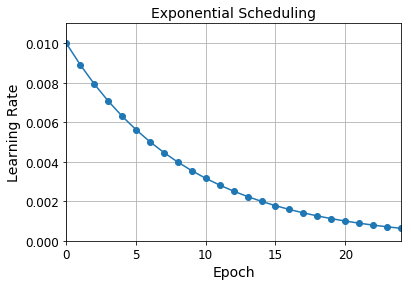

In [82]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [83]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [84]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 7s 132us/sample - loss: 0.8067 - accuracy: 0.7678 - val_loss: 0.7942 - val_accuracy: 0.7780
Epoch 2/25
55000/55000 [==============================] - 7s 122us/sample - loss: 0.6784 - accuracy: 0.7937 - val_loss: 0.8375 - val_accuracy: 0.8120
Epoch 3/25
55000/55000 [==============================] - 6s 114us/sample - loss: 0.6060 - accuracy: 0.8148 - val_loss: 0.6303 - val_accuracy: 0.8304
Epoch 4/25
55000/55000 [==============================] - 6s 114us/sample - loss: 0.5279 - accuracy: 0.8341 - val_loss: 0.5724 - val_accuracy: 0.8196
Epoch 5/25
55000/55000 [==============================] - 6s 112us/sample - loss: 0.4803 - accuracy: 0.8486 - val_loss: 0.5488 - val_accuracy: 0.8486
Epoch 6/25
55000/55000 [==============================] - 6s 113us/sample - loss: 0.4305 - accuracy: 0.8611 - val_loss: 0.4778 - val_accuracy: 0.8470
Epoch 7/25
55000/55000 [===========================

In [85]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

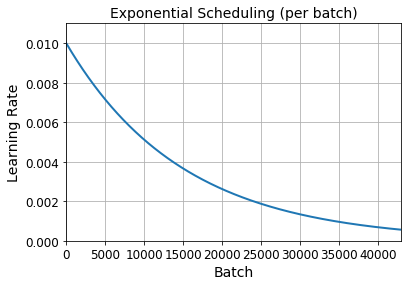

In [86]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

In [87]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [88]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [89]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 6s 111us/sample - loss: 0.8151 - accuracy: 0.7655 - val_loss: 0.6868 - val_accuracy: 0.7780
Epoch 2/25
55000/55000 [==============================] - 6s 102us/sample - loss: 0.8153 - accuracy: 0.7659 - val_loss: 1.0604 - val_accuracy: 0.7148
Epoch 3/25
55000/55000 [==============================] - 6s 104us/sample - loss: 0.9138 - accuracy: 0.7218 - val_loss: 1.3223 - val_accuracy: 0.6660
Epoch 4/25
55000/55000 [==============================] - 6s 103us/sample - loss: 0.8506 - accuracy: 0.7627 - val_loss: 0.6807 - val_accuracy: 0.8174
Epoch 5/25
55000/55000 [==============================] - 6s 101us/sample - loss: 0.7213 - accuracy: 0.8068 - val_loss: 1.0441 - val_accuracy: 0.8030
Epoch 6/25
55000/55000 [==============================] - 6s 101us/sample - loss: 0.4882 - accuracy: 0.8548 - val_loss: 0.5411 - val_accuracy: 0.8494
Epoch 7/25
55000/55000 [===========================

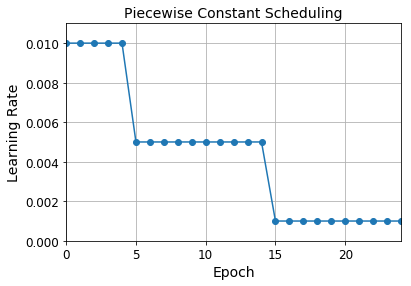

In [90]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

In [91]:
tf.random.set_seed(42)
np.random.seed(42)

In [92]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 4s 79us/sample - loss: 0.5954 - accuracy: 0.8055 - val_loss: 0.5432 - val_accuracy: 0.8154
Epoch 2/25
55000/55000 [==============================] - 4s 74us/sample - loss: 0.5194 - accuracy: 0.8345 - val_loss: 0.5184 - val_accuracy: 0.8468
Epoch 3/25
55000/55000 [==============================] - 4s 73us/sample - loss: 0.5080 - accuracy: 0.8453 - val_loss: 0.5780 - val_accuracy: 0.8384
Epoch 4/25
55000/55000 [==============================] - 4s 73us/sample - loss: 0.5360 - accuracy: 0.8452 - val_loss: 0.7195 - val_accuracy: 0.8350
Epoch 5/25
55000/55000 [==============================] - 4s 74us/sample - loss: 0.5239 - accuracy: 0.8504 - val_loss: 0.5219 - val_accuracy: 0.8562
Epoch 6/25
55000/55000 [==============================] - 4s 74us/sample - loss: 0.5163 - accuracy: 0.8528 - val_loss: 0.5669 - val_accuracy: 0.8382
Epoch 7/25
55000/55000 [==============================] -

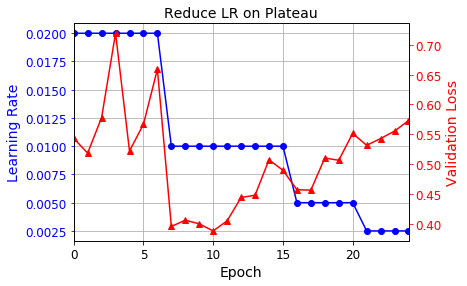

In [93]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers

In [94]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 4s 77us/sample - loss: 0.4887 - accuracy: 0.8282 - val_loss: 0.4245 - val_accuracy: 0.8526
Epoch 2/25
55000/55000 [==============================] - 4s 71us/sample - loss: 0.3830 - accuracy: 0.8641 - val_loss: 0.3798 - val_accuracy: 0.8688
Epoch 3/25
55000/55000 [==============================] - 4s 71us/sample - loss: 0.3491 - accuracy: 0.8758 - val_loss: 0.3650 - val_accuracy: 0.8730
Epoch 4/25
55000/55000 [==============================] - 4s 78us/sample - loss: 0.3267 - accuracy: 0.8839 - val_loss: 0.3564 - val_accuracy: 0.8746
Epoch 5/25
55000/55000 [==============================] - 4s 72us/sample - loss: 0.3102 - accuracy: 0.8893 - val_loss: 0.3493 - val_accuracy: 0.8770
Epoch 6/25
55000/55000 [==============================] - 4s 73us/sample - loss: 0.2969 - accuracy: 0.8939 - val_loss: 0.3400 - val_accuracy: 0.8818
Epoch 7/25
55000/55000 [==============================] -

For piecewise constant scheduling, try this:

In [95]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### 1Cycle scheduling

In [96]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [97]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

Train on 55000 samples
55000/55000 [==============================] - 2s 28us/sample - loss: nan - accuracy: 0.3888


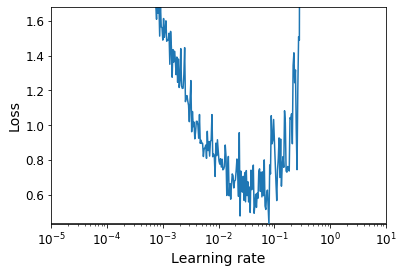

In [98]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [99]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [100]:
n_epochs = 25
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 1s 23us/sample - loss: 0.6569 - accuracy: 0.7750 - val_loss: 0.4875 - val_accuracy: 0.8300
Epoch 2/25
55000/55000 [==============================] - 1s 22us/sample - loss: 0.4584 - accuracy: 0.8391 - val_loss: 0.4390 - val_accuracy: 0.8476
Epoch 3/25
55000/55000 [==============================] - 1s 21us/sample - loss: 0.4124 - accuracy: 0.8541 - val_loss: 0.4102 - val_accuracy: 0.8570
Epoch 4/25
55000/55000 [==============================] - 1s 22us/sample - loss: 0.3842 - accuracy: 0.8643 - val_loss: 0.3893 - val_accuracy: 0.8652
Epoch 5/25
55000/55000 [==============================] - 1s 21us/sample - loss: 0.3641 - accuracy: 0.8707 - val_loss: 0.3736 - val_accuracy: 0.8678
Epoch 6/25
55000/55000 [==============================] - 1s 22us/sample - loss: 0.3456 - accuracy: 0.8781 - val_loss: 0.3652 - val_accuracy: 0.8726
Epoch 7/25
55000/55000 [==============================] -

# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [101]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [102]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 7s 128us/sample - loss: 1.6073 - accuracy: 0.8112 - val_loss: 0.7314 - val_accuracy: 0.8242
Epoch 2/2
55000/55000 [==============================] - 6s 117us/sample - loss: 0.7193 - accuracy: 0.8256 - val_loss: 0.7029 - val_accuracy: 0.8304


In [103]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 7s 129us/sample - loss: 1.6597 - accuracy: 0.8128 - val_loss: 0.7630 - val_accuracy: 0.8080
Epoch 2/2
55000/55000 [==============================] - 7s 124us/sample - loss: 0.7176 - accuracy: 0.8271 - val_loss: 0.6848 - val_accuracy: 0.8360


## Dropout

In [104]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 8s 145us/sample - loss: 0.5741 - accuracy: 0.8030 - val_loss: 0.3841 - val_accuracy: 0.8572
Epoch 2/2
55000/55000 [==============================] - 7s 134us/sample - loss: 0.4218 - accuracy: 0.8469 - val_loss: 0.3534 - val_accuracy: 0.8728


## Alpha Dropout

In [105]:
tf.random.set_seed(42)
np.random.seed(42)

In [106]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 6s 111us/sample - loss: 0.6639 - accuracy: 0.7582 - val_loss: 0.5840 - val_accuracy: 0.8410
Epoch 2/20
55000/55000 [==============================] - 5s 97us/sample - loss: 0.5517 - accuracy: 0.7968 - val_loss: 0.5747 - val_accuracy: 0.8430
Epoch 3/20
55000/55000 [==============================] - 5s 94us/sample - loss: 0.5260 - accuracy: 0.8062 - val_loss: 0.5233 - val_accuracy: 0.8486
Epoch 4/20
55000/55000 [==============================] - 5s 94us/sample - loss: 0.5055 - accuracy: 0.8136 - val_loss: 0.4687 - val_accuracy: 0.8606
Epoch 5/20
55000/55000 [==============================] - 5s 96us/sample - loss: 0.4897 - accuracy: 0.8187 - val_loss: 0.5188 - val_accuracy: 0.8588
Epoch 6/20
55000/55000 [==============================] - 5s 93us/sample - loss: 0.4812 - accuracy: 0.8217 - val_loss: 0.4929 - val_accuracy: 0.8508
Epoch 7/20
55000/55000 [==============================] 

In [107]:
model.evaluate(X_test_scaled, y_test)

10000/10000 [==============================] - 0s 39us/sample - loss: 0.4535 - accuracy: 0.8680


[0.45350628316402436, 0.868]

In [108]:
model.evaluate(X_train_scaled, y_train)

55000/55000 [==============================] - 2s 41us/sample - loss: 0.3357 - accuracy: 0.8887


[0.335701530437036, 0.88872725]

In [109]:
history = model.fit(X_train_scaled, y_train)

## MC Dropout

In [110]:
tf.random.set_seed(42)
np.random.seed(42)

In [111]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [112]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],
      dtype=float32)

In [113]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0

In [114]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],
      dtype=float32)

In [115]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [116]:
y_pred = np.argmax(y_proba, axis=1)

In [117]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.868

In [118]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [119]:
tf.random.set_seed(42)
np.random.seed(42)

In [120]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [121]:
mc_model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_33 (Flatten)         (None, 784)               0         
_________________________________________________________________
mc_alpha_dropout_3 (MCAlphaD (None, 784)               0         
_________________________________________________________________
dense_311 (Dense)            (None, 300)               235500    
_________________________________________________________________
mc_alpha_dropout_4 (MCAlphaD (None, 300)               0         
_________________________________________________________________
dense_312 (Dense)            (None, 100)               30100     
_________________________________________________________________
mc_alpha_dropout_5 (MCAlphaD (None, 100)               0         
_________________________________________________________________
dense_313 (Dense)            (None, 10)              

In [122]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [123]:
mc_model.set_weights(model.get_weights())

Now we can use the model with MC Dropout:

In [124]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.17, 0.  , 0.19, 0.  , 0.64]],
      dtype=float32)

## Max norm

In [125]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [126]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 8s 147us/sample - loss: 0.4745 - accuracy: 0.8329 - val_loss: 0.3988 - val_accuracy: 0.8584
Epoch 2/2
55000/55000 [==============================] - 7s 135us/sample - loss: 0.3554 - accuracy: 0.8688 - val_loss: 0.3681 - val_accuracy: 0.8726


# Exercises

## 1. to 7.

See appendix A.

## 8. Deep Learning

### 8.1.

_Exercise: Build a DNN with five hidden layers of 100 neurons each, He initialization, and the ELU activation function._

### 8.2.

_Exercise: Using Adam optimization and early stopping, try training it on MNIST but only on digits 0 to 4, as we will use transfer learning for digits 5 to 9 in the next exercise. You will need a softmax output layer with five neurons, and as always make sure to save checkpoints at regular intervals and save the final model so you can reuse it later._

### 8.3.

_Exercise: Tune the hyperparameters using cross-validation and see what precision you can achieve._

### 8.4.

_Exercise: Now try adding Batch Normalization and compare the learning curves: is it converging faster than before? Does it produce a better model?_

### 8.5.

_Exercise: is the model overfitting the training set? Try adding dropout to every layer and try again. Does it help?_

## 9. Transfer learning

### 9.1.

_Exercise: create a new DNN that reuses all the pretrained hidden layers of the previous model, freezes them, and replaces the softmax output layer with a new one._

### 9.2.

_Exercise: train this new DNN on digits 5 to 9, using only 100 images per digit, and time how long it takes. Despite this small number of examples, can you achieve high precision?_

### 9.3.

_Exercise: try caching the frozen layers, and train the model again: how much faster is it now?_

### 9.4.

_Exercise: try again reusing just four hidden layers instead of five. Can you achieve a higher precision?_

### 9.5.

_Exercise: now unfreeze the top two hidden layers and continue training: can you get the model to perform even better?_

## 10. Pretraining on an auxiliary task

In this exercise you will build a DNN that compares two MNIST digit images and predicts whether they represent the same digit or not. Then you will reuse the lower layers of this network to train an MNIST classifier using very little training data.

### 10.1.
Exercise: _Start by building two DNNs (let's call them DNN A and B), both similar to the one you built earlier but without the output layer: each DNN should have five hidden layers of 100 neurons each, He initialization, and ELU activation. Next, add one more hidden layer with 10 units on top of both DNNs. You should use the `keras.layers.concatenate()` function to concatenate the outputs of both DNNs, then feed the result to the hidden layer. Finally, add an output layer with a single neuron using the logistic activation function._

### 10.2.
_Exercise: split the MNIST training set in two sets: split #1 should containing 55,000 images, and split #2 should contain contain 5,000 images. Create a function that generates a training batch where each instance is a pair of MNIST images picked from split #1. Half of the training instances should be pairs of images that belong to the same class, while the other half should be images from different classes. For each pair, the training label should be 0 if the images are from the same class, or 1 if they are from different classes._

### 10.3.
_Exercise: train the DNN on this training set. For each image pair, you can simultaneously feed the first image to DNN A and the second image to DNN B. The whole network will gradually learn to tell whether two images belong to the same class or not._

### 10.4.
_Exercise: now create a new DNN by reusing and freezing the hidden layers of DNN A and adding a softmax output layer on top with 10 neurons. Train this network on split #2 and see if you can achieve high performance despite having only 500 images per class._